# Introducción al Aprendizaje Profundo &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; UANL - FCFM
---
## Autoencoder para la eliminacion de ruido en imagenes

**Alumnos**
- Ian Mauricio Saucedo Alemán &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1868954

## Lectura y formato

Importando librerias necesarias

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

Cargamos el dataset mnist, no necesitaremos las etiquetas en este caso

In [ ]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
print('Max value in the x_train is', x_train[0].max())
print('Min value in the x_train is', x_train[0].min())

4431872/4422102 [==============================] - 0s 0us/step
Max value in the x_train is 255
Min value in the x_train is 0


Podemos visualizar algunas de las imagenes del dataset

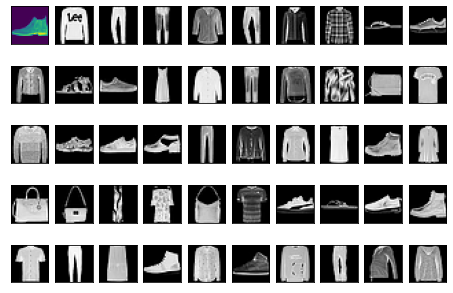

<Figure size 360x720 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(5, 10)
plt.figure(figsize=(5, 10))
fig.tight_layout(pad=-1)
a = 0
for i in range(5):
    for j in range(10):
        axs[i, j].imshow(tf.squeeze(x_test[a]))
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)
        a = a + 1
        plt.gray()

Normalizamos los valores de nuestros datos a valores de 0 a 1

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Hacemos un reshape de nuestros datos

In [ ]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Agregaremos un ruido random a nuestros datos, cuya magnitud dependera del factor de ruido 

In [ ]:
noise_factor = 0.6
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

Volvemos a normalizar nuestros datos a valores entre 0 y 1

In [ ]:
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Podemos visualizar nuestros datos con el ruido añadido

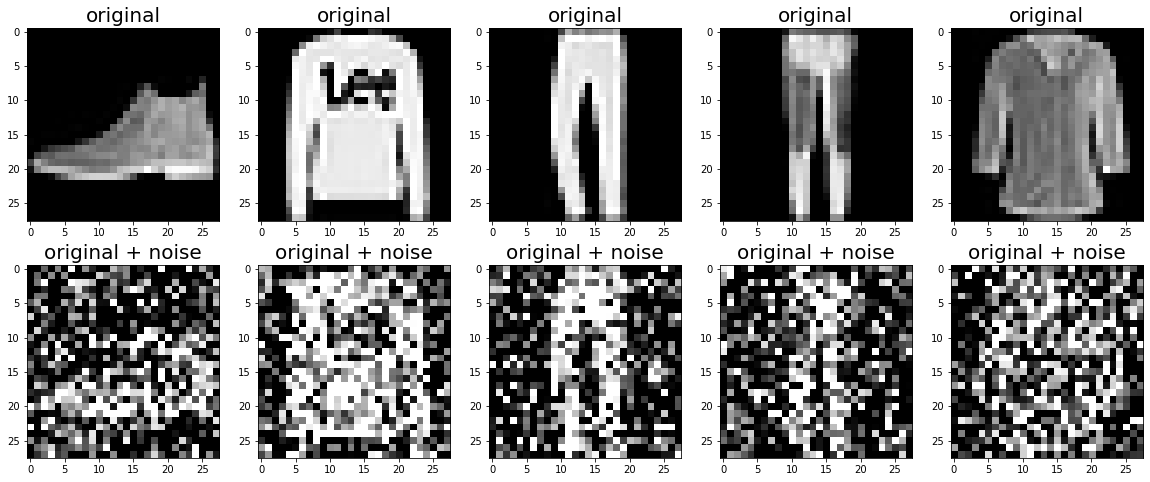

In [ ]:
n = 5
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original", size=20)
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    bx = plt.subplot(2, n, n+ i + 1)
    plt.title("original + noise", size=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Modelado de autoencoder

Definimos la arquitectura de nuestro modelo, donde se utilizaran dos capas de convolucion para codificar los datos, asi como dos capas de convolucion para realizar la decodificacion

In [ ]:
class Denoise(tf.keras.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(28, 28, 1)),
      Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

Utilizaremos ADAM como algoritmo de optimizacion y MSE como funcion de perdida

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

Finalmente entrenamos nuestro modelo con nuestros datos con ruido

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 65s 34ms/step - loss: 0.0353 - val_loss: 0.0258
Epoch 2/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 3/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0247 - val_loss: 0.0245
Epoch 4/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0243 - val_loss: 0.0245
Epoch 5/10
1875/1875 [==============================] - 68s 37ms/step - loss: 0.0240 - val_loss: 0.0239
Epoch 6/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0237 - val_loss: 0.0238
Epoch 7/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0235 - val_loss: 0.0237
Epoch 8/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0234 - val_loss: 0.0236
Epoch 9/10
1875/1875 [==============================] - 72s 39ms/step - loss: 0.0233 - val_loss: 0.0233
Epoch 10/10
1875/1875 [==============================] - 74s 39m

Podemos observar tambien la arquitectura del modelo

In [ ]:
autoencoder.encoder.summary(), autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                      

(None, None)

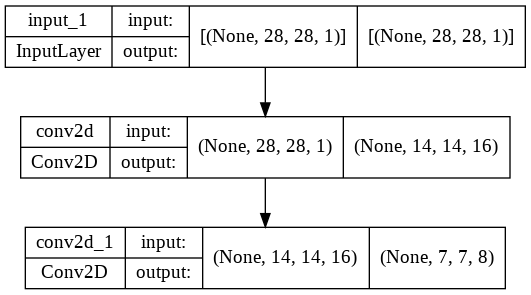

In [ ]:
tf.keras.utils.plot_model(
    autoencoder.encoder, show_shapes=True, 
    show_layer_names=True)

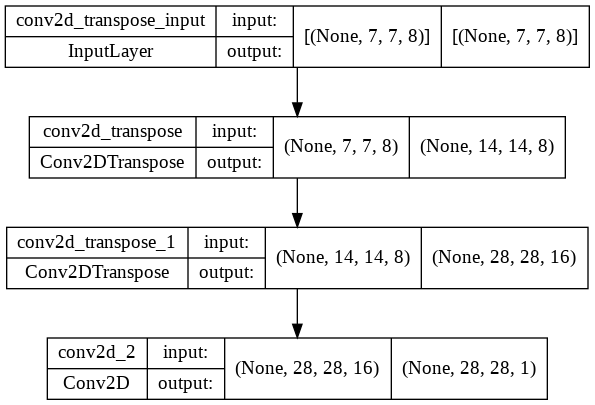

In [ ]:
tf.keras.utils.plot_model(
    autoencoder.decoder, show_shapes=True, 
    show_layer_names=True)

El modelo recibe las imagenes de 28x28, las codifica con convoluciones y decodifica volviendo a una dimension de 28x28 eliminando ruidos

## Pruebas de eliminacion de ruido con el autoencoder

Ya podemos realizar una limpieza de ruido con nuestro autoencoder entrenado

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

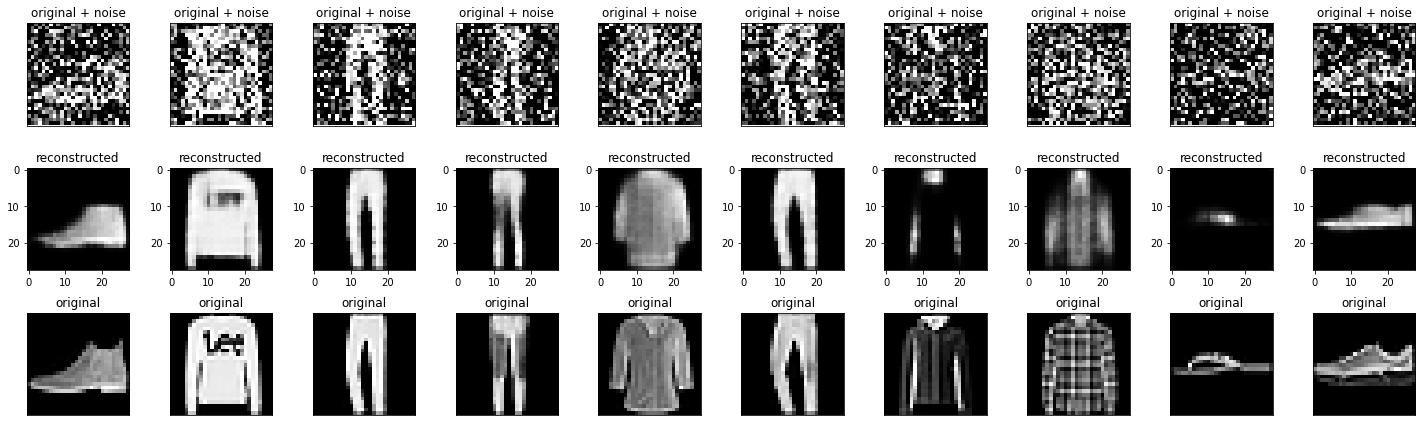

In [ ]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
# display original + noise
    bx = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    cx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    # display original
    ax = plt.subplot(3, n, i + 2*n + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Se puede observar que el autoencoder simple tiene un muy buen rendimiento en la eliminacion de ruido de las imagenes, obteniendo una limpieza de imagenes bastante buena para datos con mucho ruido